# AE4350 - Bio-inspired Intelligence and Learning Assignment
This is the Main notebook for training and testing the DRL portfolio management system
<br>Created on Thu May 12 13:22:50 2022
<br>@author: Reinier Vos, 4663160-TUD

In [1]:
from utility_v5 import Agent, getData, getState, formatPrice
#from AE4350_Assignment.utility_v5 import Agent, getData, getState, formatPrice
import sys
from tqdm import tqdm # gives progress bar when loading
import os
import numpy as np
import pandas as pd
import json
import plotly.graph_objects as go
#In TensorFlow 2.3+, you can disable eager mode anytime using the following method:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import plotly.graph_objects as pgo
import time
#tf.config.run_functions_eagerly(True)
#tf.config.run_functions_eagerly(False)

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

### README
<br> Ensure utility v5 is used!
<br> This version has is the google colab compatible version, change next cell for desired environment

In [2]:
# github link

using_colab = False
pay = False # whether youre using the payed version (i.e. own server)

if using_colab:
    from google.colab import files
    if not pay:
        from google.colab import drive
        import shutil
        drive.mount('/content/drive', force_remount=True)
    !git clone https://github.com/rwvosTUD/AE4350_Assignment.git

In [3]:
window_size = 100 
batch_size = 64 #32
checkpoint_dir = "run3_colab"
data_extraWindow = 1 # moving average window, do note that this will reduce the data length!
data, data_extra = getData("traindata",data_extraWindow, colab = using_colab)
l = len(data) - 1
episode_count = 300
n_budget = 1 # budget based howmany assets you can buy at the start
terminate_threshold = 0.10
hidden_units = [32, 64, 32, 64] # [32, 64, 32, 64] default,first 2 for actor, last 2 for critic
regularizer = 1e-6 # 1e-6 default


agent = Agent(window_size, batch_size, hidden_units, regularizer,
              data[0], n_budget, terminate_threshold,
              checkpoint_dir, rewardType = 3, data_extraWindow = data_extraWindow) 
print("=== ATTENTION: running model for {} stocks ===".format(n_budget))

Models will be saved to C:\Users\Reinier Vos\Documents\YEAR2021_2022\AE MSc C&S\AE4350-Bio_inspiredIntelligenceAndLearning\assignment\scripts\run3_colab
Reward function description: terminal reward and penalty for buy hold, no intermediary
Succesfully saved model parameters to folder run3_colab
=== ATTENTION: running model for 1 stocks ===


C:\Users\Reinier Vos\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
### loading of model
#load_dir = "runs/run3"
#agent.load_models(load_dir,40)
#load_dir = "runs/version3/run6_r5"
if using_colab:
    load_dir = "AE4350_Assignment/prev_runs/n{0}prev_run".format(n_budget)
else:
    load_dir = "runs/run1"
agent.load_models(load_dir,90)

OSError: Unable to open file (unable to open file: name = 'C:\Users\Reinier Vos\Documents\YEAR2021_2022\AE MSc C&S\AE4350-Bio_inspiredIntelligenceAndLearning\assignment\scripts\runs/run1\e90\actor_local.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Setup naive benchmark, buy and hold for training data
fig = pgo.Figure()
fig.update_layout(showlegend=True, title_text ="Training data")
fig.add_trace(pgo.Scatter(x=np.arange(len(data)), y=data,
                    mode='lines',
                    name='stock growth'))
fig.add_trace(pgo.Scatter(x=np.arange(len(data_extra)), y=data_extra,
                    mode='lines',
                    name='stock MA adjusted W ={}'.format(data_extraWindow)))
fig.show()
growth_buyhold_per = (data[-1]-data[0])/data[0]

print("Naive buy & hold strategy on TRAINIING data has a portfolio growth of {0}% per asset bought at the start of 2006 and sold at 2015".format(round(growth_buyhold_per,3)))
growth_buyhold_cash = agent.budget*growth_buyhold_per
growth_buyhold = (agent.n_budget*(data-data[0]))[0:-1]
print("For current budget of {0}, this means {1} stocks bought in 2006 result in a final portfolio growth of {2} (i.e. final value ={3})".format(formatPrice(agent.budget),
                                                                                                                                                 agent.n_budget,
                                                                                                                                                 formatPrice(growth_buyhold_cash),
                                                                                                                                                 formatPrice(growth_buyhold_cash+agent.budget)))

In [ ]:
showfigs = False
saveIter = 10
start = 0
scaling = 0.1 #0.02
tbzip_folder="/content/{0}_z.zip".format(checkpoint_dir)
zip_folder = "/content/{0}".format(checkpoint_dir)

#pbar = tqdm(total=l*episode_count, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') # progress bar
#pbar = tqdm(total=episode_count, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') # progress bar
totalReward_list = []
lastLosses_list=[]
everyProfit_dct = {}
everyBalance_dct = {}
everyReward_dct = {}
everyInventory_dct = {}
everyGrowth_dct = {}
everyGrowth_dct["buyhold"] = growth_buyhold.tolist()
everyCompete_dct = {}
everyLoss_dct = {}
agent.is_eval = False

fig = pgo.Figure()
fig.update_layout(showlegend=True)
for e in range(start,episode_count):
    pbar = tqdm(total=l, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') # progress bar
    #print("== Episode " + str(e) + "/" + str(episode_count) +" ==")
    agent.reset(data[0])
    state = getState(agent, data, 0, window_size + 1)

    total_reward = 0 # total profit resets every epsiode 
    n_trades = 0 
    profits = []
    balances = []
    rewards = []
    inventories = [] # inventory value (only stocks)
    actor_local_losses = []
    buy_ind = []
    sell_ind = []
    pt1 = data_extra[-1]
    
    done = False
    for t in range(l):
        profit = 0 # initialize
        change = 0 
        sale_profit = 0
        action, action_prob = agent.act(state)
        next_state = getState(agent, data, t + 1, window_size + 1)

        if action == 1 and agent.balance > data[t]:
            # buying stock, only if there is balance though
            agent.inventory.append(data[t])
            #agent.inventory_ma.append(data_extra[t])
            change = -data[t]
            buy_ind.append(t)
            
        elif action == 2 and len(agent.inventory) > 0:
            # selling stock, only if there are stocks held

            bought_price = agent.inventory.pop(0)
            #sale_profit = data[t]-bought_price
            profit = data[t] - bought_price 
            
            #profit = agent.balance + agent.inventory_value - growth_buyhold[t] # profit vs buyhold
            '''
            _ = agent.inventory.pop(0)
            bought_price = agent.inventory_ma.pop(0)
            profit = data_extra[t]-bought_price
            '''
            change = data[t]
            sell_ind.append(t)
            n_trades += 1
       
        '''
        else:
            # hold stocks
            profit = 0 # explicit reset
            change = 0
            terminate = agent.update_balance(0,inventory_value) # check portfolio based on stock changes
        # all statement done in else loop are initialized at start of iteration
        '''
        agent.update_balance(change)
        agent.update_inventory(data[t])
        terminate = agent.check_threshold()
        if terminate or t == l-1:
            # terminating i.e. last iteration 
            done = True # terminal state has no 'next' so change done variable before use in next lines
            
        '''
        ================= PROFIT EXPERIMENT ===================
        we reward points whenever the portfolio is above buyhold! sort of cartpole balancing point awarding 
        we clip it at max(0,a) because we dont want to overfit!

        diff = agent.balance + agent.inventory_value - data[t]*agent.n_budget
        if diff > 0:
            #portfolio worth more than buy hold, hold this position
            profit = sale_profit #diff*scaling+sale_profit # cartpole balancing term + risk term
        else:
        '''
        #portfolio worth less than buy hold, try to make up; 
        #notice we dont look at the portfolio value anymore
        '''
            profit = sale_profit # only risk term
            # add penalty term? or maybe inflate balance in order to make it more risky
           
        
        ======================================================
        '''
        #price = data[t]
        
        
        if t < data_extraWindow:
            ptn = data_extra[t]
        else: 
            ptn = data[t-data_extraWindow]
        util_lst = [data[t],pt1, ptn, action, n_trades]
        pt1 = data[t]
        '''
        change names of variables if it works
        '''
        reward = agent.get_reward(agent, profit, util_lst, done)
        total_reward += reward
        actor_local_loss = agent.step(action_prob, reward, next_state, done)
        state = next_state

        # collect 
        balances.append(agent.balance)
        inventories.append(agent.inventory_value)
        profits.append(profit)
        rewards.append(reward)
        actor_local_losses.append(float(actor_local_loss))
        
        if terminate:
            # ensure consistent length of arrays then terminate trial
            balances = np.pad(balances,(0,l-t-1),'constant',constant_values=(0,balances[-1])).tolist()
            inventories = np.pad(inventories,(0,l-t-1),'constant',constant_values=(0,inventories[-1])).tolist()
            profits = np.pad(profits,(0,l-t-1),'constant',constant_values=(0,0)).tolist()
            rewards = np.pad(rewards,(0,l-t-1),'constant',constant_values=(0,0)).tolist()
            actor_local_losses = np.pad(rewards,(0,l-t-1),'constant',constant_values=(0,actor_local_loss[-1])).tolist()
            print("Episode {0} was terminated at {1}/{2} due to terminal balance state".format(e,t,l))
            break
        
        pbar.set_description("Episode {0}| Portfolio: {1}| Balance: {2}| Inventory: {3}| RewardAcc: {4}".format(int(e),
                                                                                                                formatPrice(agent.balance+agent.inventory_value),
                                                                                                                formatPrice(agent.balance),
                                                                                                                formatPrice(agent.inventory_value),
                                                                                                                formatPrice(total_reward)))
        pbar.update()

        
    # collect & save
    growth = (np.array(balances)+np.array(inventories)-agent.budget).tolist() # 
    compete = (np.array(growth)-growth_buyhold).tolist() # compete vs buyhold
    
    totalReward_list.append(total_reward)
    lastLosses_list.append(actor_local_loss)
    everyProfit_dct["e{}".format(e)] = profits
    everyBalance_dct["e{}".format(e)] = balances
    everyReward_dct["e{}".format(e)] = rewards
    everyInventory_dct["e{}".format(e)] = inventories
    everyGrowth_dct["e{}".format(e)] = growth
    everyCompete_dct["e{}".format(e)] = compete
    everyLoss_dct["e{}".format(e)] = actor_local_losses
    
    if e % saveIter == 0 and e != 0:
        agent.save_models(e)
        with open(f'./{checkpoint_dir}/e{e}/totalReward.npy', 'wb') as f:
            np.save(f, np.array(totalReward_list))
        with open(f'./{checkpoint_dir}/e{e}/Losses.npy', 'wb') as f:
            np.save(f, np.array(lastLosses_list))
        with open(f'./{checkpoint_dir}/e{e}/EveryProfit.json', 'w') as fp:
            json.dump(everyProfit_dct, fp)
        with open(f'./{checkpoint_dir}/e{e}/EveryBalance.json', 'w') as fp:
            json.dump(everyBalance_dct, fp)
        with open(f'./{checkpoint_dir}/e{e}/EveryReward.json', 'w') as fp:
            json.dump(everyReward_dct, fp)
        with open(f'./{checkpoint_dir}/e{e}/everyInventory.json', 'w') as fp:
            json.dump(everyInventory_dct, fp)
        with open(f'./{checkpoint_dir}/e{e}/everyLoss.json', 'w') as fp:
            json.dump(everyLoss_dct, fp)
        # plot
        fig.update_layout(showlegend=True, title_text = "E{3} final profit RL: {0} vs buyhold: {1}, difference = {2}".format(round(growth[-1],2),round(growth_buyhold[-1],2),round(abs(growth[-1]-growth_buyhold[-1]),2),e))
        fig.add_trace(pgo.Scatter(x=np.arange(len(data)), y=data,
                            mode='lines',
                            name='data'))
        fig.add_trace(pgo.Scatter(x=buy_ind, y=data[buy_ind], marker_color = "green",
                            mode='markers',
                            name='buy'))
        fig.add_trace(pgo.Scatter(x=sell_ind, y=data[sell_ind], marker_color = "red",
                            mode='markers',
                            name='sell'))
        if showfigs:
            fig.show(render = "browser")
        fig.write_html("./{0}/results/e{1}_trades.html".format(checkpoint_dir,e))
        fig.data = [] # reset traces
        if using_colab:
            !zip -r "$tbzip_folder" "$zip_folder"
            print("Zip file created, saved next run")
        
    if max(e-1,0) % saveIter == 0 and e != 0 and e != 1:
        # we skip one iteration as we assume the zip file creation is done now
        if using_colab and not pay: 
            #!zip -r /content/run1_colab_r3v2.zip /content/run1_colab
            #files.download(tbzip_folder)
            shutil.copy(tbzip_folder, "/content/drive/MyDrive")
            #b = 1
            #print("Attempting download, system sleep initiated")
            #time.sleep(24) # Sleep system for x seconds, to give time for download
            #print("System sleep terminated, continueing...")
    

In [ ]:
# final save
agent.save_models(310)
if using_colab:
    #!zip -r /content/run1_colab_r3v2.zip /content/run1_colab
    !zip -r "$tbzip_folder" "$zip_folder"
    files.download(tbzip_folder)

In [ ]:
# Manually save results
'''
with open(f'./models/{runName}/{runName}_parameters.txt', 'w') as f:
    print(allParameters, file=f)

# Saving results
with open(f'./{checkpoint_dir}/results/total_rewards.npy', 'wb') as f:
    np.save(f, np.array(total_reward_list))
with open(f'./{checkpoint_dir}/results/EveryProfit_dct.json', 'w') as fp:
    json.dump(EveryProfit_dct, fp)
'''

In [ ]:
# loading results
'''
with open(f'./{checkpoint_dir}/total_rewards.npy', 'rb') as f:
    total_reward_list = np.load(f)
with open(f'./{checkpoint_dir}/EveryProfit_dct.json', 'r') as fp:
    EveryProfit_dct = json.load(fp)
'''

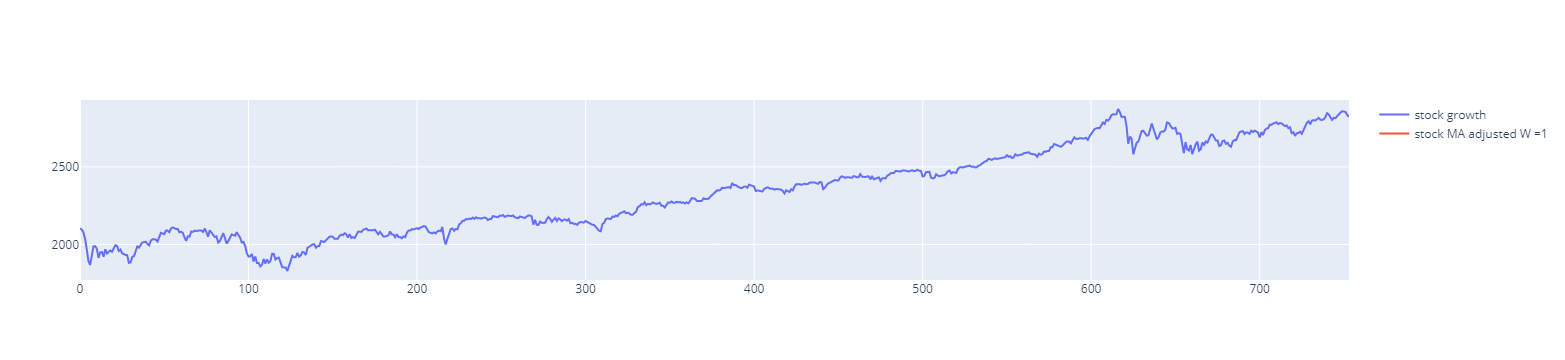

Naive buy & hold strategy on TEST data has a portfolio growth of 0.342% per asset bought at the start of 2015 and sold at 2018
For current budget of +$2102.44, this means that for 1 stocks bought in 2015 and sold in 2018 one achieves a final portfolio growth of +$719.49


In [8]:
# Setup naive benchmark, buy and hold for training data
test_data, test_data_extra = getData("testdata", data_extraWindow)
data = test_data
data_extra = test_data_extra
fig = pgo.Figure()
fig.update_layout(showlegend=True)
fig.add_trace(pgo.Scatter(x=np.arange(len(test_data)), y=test_data,
                    mode='lines',
                    name='stock growth'))
fig.add_trace(pgo.Scatter(x=np.arange(len(test_data_extra)), y=test_data_extra,
                    mode='lines',
                    name='stock MA adjusted W ={}'.format(data_extraWindow)))
fig.show()
growth_buyhold_per = (data[-1]-data[0])/data[0]

print("Naive buy & hold strategy on TEST data has a portfolio growth of {0}% per asset bought at the start of 2015 and sold at 2018".format(round(growth_buyhold_per,3)))
growth_buyhold_cash = agent.n_budget*data[0]*growth_buyhold_per
growth_buyhold = (agent.n_budget*(data-data[0]))[0:-1]
print("For current budget of {0}, this means that for {1} stocks bought in 2015 and sold in 2018 one achieves a final portfolio growth of {2}".format(formatPrice(agent.n_budget*data[0]),agent.n_budget,formatPrice(growth_buyhold_cash)))

In [23]:
load_dir = "runs/colab/content/run4_colab"
checkpoint_dir = load_dir
agent.load_models(load_dir,80)
agent.load_attributes(load_dir)

Succesfully loaded models from folder runs/colab/content/run4_colab and episode 80
Succesfully loaded model parameters from folder runs/colab/content/run4_colab


In [ ]:
# saving of results will be to

Testing of model| portfolio value: +$1957.69 | Balance: +$1957.69 | total reward: -$875.59: 100%|████████████| 753/753 
Testing of model| portfolio value: +$1940.23 | Balance: +$1940.23 | total reward: -$893.05: 100%|████████████| 753/753 

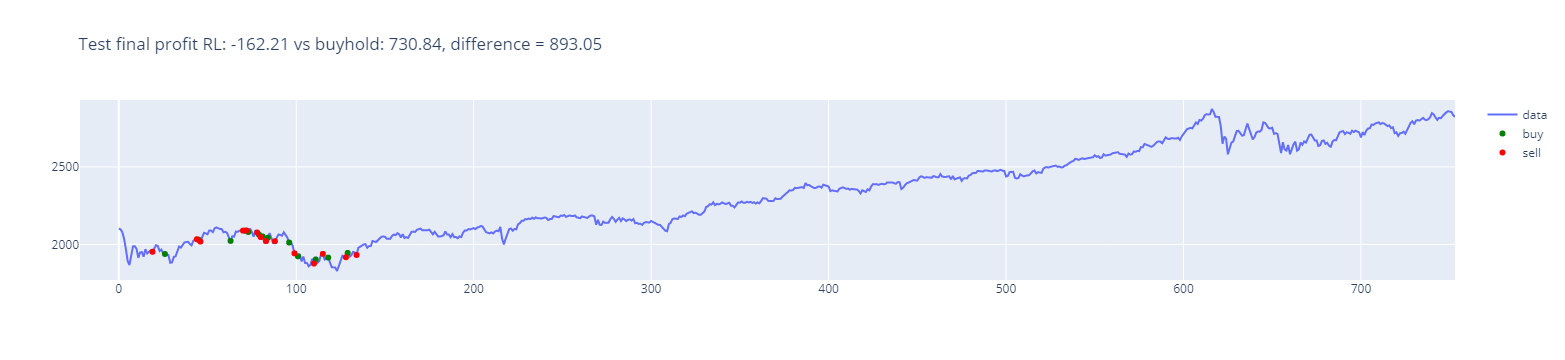

NameError: name 'e' is not defined

In [19]:
# Validation cell
data = test_data # sanity check
data_extra = test_data_extra
l = len(data) - 1
agent.is_eval = True
agent.budget = agent.n_budget*data[0]
done = False
terminate = False
showfigs = True

# initialize and container setup
state = getState(agent, data, 0, window_size + 1)
agent.reset(data[0])
total_reward = 0
profits = []
balances = []
rewards = []
inventories = [] # inventory value (only stocks)
actor_local_losses = []
sell_ind = []
buy_ind = []
pbar = tqdm(total=l, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') # progress bar
pt1 = data_extra[-1]
fig = pgo.Figure()
fig.update_layout(showlegend=True)
for t in range(l):
    profit = 0 # initialize
    change = 0 
    sale_profit = 0
    action, action_prob = agent.act(state)
    next_state = getState(agent, data, t + 1, window_size + 1)

    if action == 1 and agent.balance > data[t]:
        # buying stock, only if there is balance though
        agent.inventory.append(data[t])
        #agent.inventory_ma.append(data_extra[t])
        change = -data[t]
        buy_ind.append(t)

    elif action == 2 and len(agent.inventory) > 0:
        # selling stock, only if there are stocks held

        bought_price = agent.inventory.pop(0)
        #sale_profit = data[t]-bought_price
        profit = data[t] - bought_price 

        #profit = agent.balance + agent.inventory_value - growth_buyhold[t] # profit vs buyhold
        '''
        _ = agent.inventory.pop(0)
        bought_price = agent.inventory_ma.pop(0)
        profit = data_extra[t]-bought_price
        '''
        change = data[t]
        sell_ind.append(t)

    '''
    else:
        # hold stocks
        profit = 0 # explicit reset
        change = 0
        terminate = agent.update_balance(0,inventory_value) # check portfolio based on stock changes
    # all statement done in else loop are initialized at start of iteration
    '''
    agent.update_balance(change)
    agent.update_inventory(data[t])
    terminate = agent.check_threshold()
    if terminate or t == l-1:
        # terminating i.e. last iteration 
        done = True # terminal state has no 'next' so change done variable before use in next lines

    '''
    ================= PROFIT EXPERIMENT ===================
    we reward points whenever the portfolio is above buyhold! sort of cartpole balancing point awarding 
    we clip it at max(0,a) because we dont want to overfit!

    diff = agent.balance + agent.inventory_value - data[t]*agent.n_budget
    if diff > 0:
        #portfolio worth more than buy hold, hold this position
        profit = sale_profit #diff*scaling+sale_profit # cartpole balancing term + risk term
    else:
    '''
    #portfolio worth less than buy hold, try to make up; 
    #notice we dont look at the portfolio value anymore
    '''
        profit = sale_profit # only risk term
        # add penalty term? or maybe inflate balance in order to make it more risky


    ======================================================
    '''
    #price = data[t]


    if t < data_extraWindow:
        ptn = data_extra[t]
    else: 
        ptn = data[t-data_extraWindow]
    util_lst = [data[t],pt1, ptn, action, n_trades]
    pt1 = data[t]
    '''
    change names of variables if it works
    '''
    reward = agent.get_reward(agent, profit, util_lst, done)
    total_reward += reward
    actor_local_loss = agent.step(action_prob, reward, next_state, done)
    state = next_state

    # collect 
    balances.append(agent.balance)
    inventories.append(agent.inventory_value)
    profits.append(profit)
    rewards.append(reward)
    actor_local_losses.append(float(actor_local_loss))

    if terminate:
        # ensure consistent length of arrays then terminate trial
        balances = np.pad(balances,(0,l-t-1),'constant',constant_values=(0,balances[-1])).tolist()
        inventories = np.pad(inventories,(0,l-t-1),'constant',constant_values=(0,inventories[-1])).tolist()
        profits = np.pad(profits,(0,l-t-1),'constant',constant_values=(0,0)).tolist()
        rewards = np.pad(rewards,(0,l-t-1),'constant',constant_values=(0,0)).tolist()
        actor_local_losses = np.pad(rewards,(0,l-t-1),'constant',constant_values=(0,actor_local_loss[-1])).tolist()
        print("Episode {0} was terminated at {1}/{2} due to terminal balance state".format(e,t,l))
        break
        
    pbar.set_description("Episode {0}| Portfolio: {1}| Balance: {2}| Inventory: {3}| RewardAcc: {4}".format(int(e),
                                                                                                            formatPrice(agent.balance+agent.inventory_value),
                                                                                                            formatPrice(agent.balance),
                                                                                                            formatPrice(agent.inventory_value),
                                                                                                            formatPrice(total_reward)))
    pbar.update()
    

    # collect & save
growth = (np.array(balances)+np.array(inventories)-agent.budget).tolist() # 
compete = (np.array(growth)-growth_buyhold).tolist() # compete vs buyhold

fig.update_layout(showlegend=True, title_text = "Test final profit RL: {0} vs buyhold: {1}, difference = {2}".format(round(growth[-1],2),round(growth_buyhold[-1],2),round(abs(growth[-1]-growth_buyhold[-1]),2)))
fig.add_trace(pgo.Scatter(x=np.arange(len(data)), y=data,
                    mode='lines',
                    name='data'))
fig.add_trace(pgo.Scatter(x=buy_ind, y=data[buy_ind], marker_color = "green",
                    mode='markers',
                    name='buy'))
fig.add_trace(pgo.Scatter(x=sell_ind, y=data[sell_ind], marker_color = "red",
                    mode='markers',
                    name='sell'))
if showfigs:
    fig.show(render = "browser")
fig.write_html("./{0}/results/test_trades.html".format(checkpoint_dir))
    
# collect & save
save_df = {"balance":balances,"inventory":inventories,"profit":profits,"reward":rewards,"growth":growth,"compete":compete,"growth_buyhold":growth_buyhold.tolist()}
save_df = pd.DataFrame(save_df).to_csv("./{0}/results/res_validation.csv".format(checkpoint_dir))
print("succesfully saved csv file")

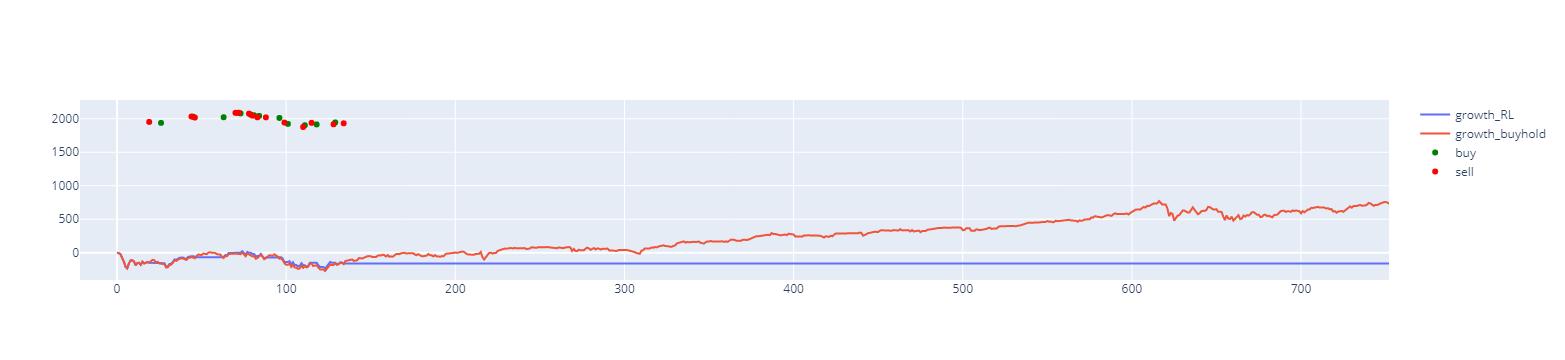

In [25]:
## Plotting RL vs buyhold
fig = pgo.Figure()
fig.update_layout(showlegend=True)
fig.add_trace(pgo.Scatter(x=np.arange(len(growth)), y=np.array(growth),
                    mode='lines',
                    name='growth_RL'))
fig.add_trace(pgo.Scatter(x=np.arange(len(growth)), y=np.array(growth_buyhold),
                    mode='lines',
                    name='growth_buyhold'))
fig.add_trace(pgo.Scatter(x=buy_ind, y=data[buy_ind], marker_color = "green",
                    mode='markers',
                    name='buy'))
fig.add_trace(pgo.Scatter(x=sell_ind, y=data[sell_ind], marker_color = "red",
                    mode='markers',
                    name='sell'))
fig.show()

# testing whether model even learnt
model1 = Agent(window_size, batch_size)
model1 = model1.critic_target.model
a= model1.get_weights()
print(a[10])
print("=================================")
model2 = Agent(window_size, batch_size)
model2.critic_target.model.load_weights("./run1/e203/critic_local.h5")
b =model2.critic_target.model.get_weights()
print(b[10])

In [ ]:
growth_buyhold[100]